In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from IPython.display import Audio, display
from scipy.signal import find_peaks
from torchcodec.decoders import AudioDecoder

from zerosyl import WavLM

This notebook contains the basic steps of our method.
This will be easier to follow along with than the packaged code in `zerosyl/zerosyl.py`.

Load WavLM Large

In [2]:
wavlm = WavLM.from_remote().cuda()

Load a waveform

In [3]:
decoder = AudioDecoder("data/sample.flac", sample_rate=16000, num_channels=1)
audio = decoder.get_all_samples()
wav = audio.data

display(Audio(wav, rate=16000))

Preprocess the waveform

In [4]:
# loudness normalization
wav = torch.nn.functional.layer_norm(wav, wav.shape)
# zero-pad such that the output features will be perfectly aligned with 20ms intervals
wav = torch.nn.functional.pad(wav, ((400 - 320) // 2, (400 - 320) // 2))

Extract boundary features from layer 13

In [5]:
with torch.inference_mode():
    boundary_features, _ = wavlm.extract_features(wav.cuda(), output_layer=13)

boundary_features = boundary_features.squeeze(0).cpu().numpy()

Perform boundary detection

In [6]:
# compute the L2 norm signal
norms = np.linalg.norm(boundary_features, axis=-1)

# normalize the norm signal
norms = (norms - norms.mean()) / norms.std()

# smooth the L2 norm signal
kernel = np.ones(3) / 3
pad_len = 3 // 2
norms_padded = np.pad(norms, (pad_len, pad_len), mode="edge")
norms_smooth = np.convolve(norms_padded, kernel, mode="valid")

# performan prominence based peak detection
peaks, _ = find_peaks(norms_smooth, prominence=0.45)

# use peaks to detemine boundaries
boundaries = [0] + peaks.tolist() + [len(boundary_features)]

Visualize the boundaries

In [7]:
# compute mel spectrogram
tMel = torchaudio.transforms.MelSpectrogram(
    n_fft=1024,
    win_length=400,
    hop_length=320,
)
tDB = torchaudio.transforms.AmplitudeToDB(top_db=80)
melspec = tDB(tMel(audio.data.squeeze()))

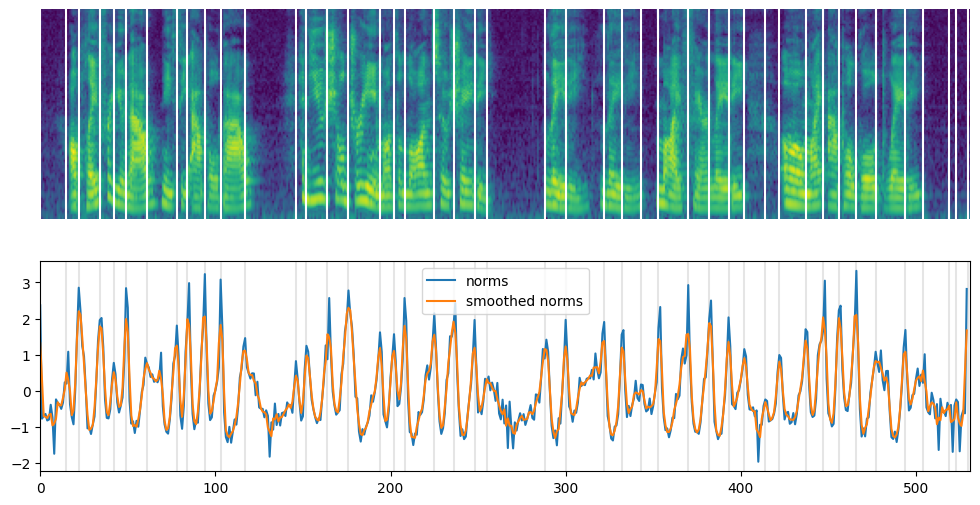

In [8]:
xmin, xmax = 0, melspec.size(1)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.imshow(melspec, aspect="auto", origin="lower")
plt.axis("off")
for b in boundaries:
    plt.axvline(b, c="w")
plt.xlim(xmin, xmax)

plt.subplot(2, 1, 2)
for b in boundaries:
    plt.axvline(b, c="gray", alpha=0.2)
plt.plot(norms, label="norms")
plt.plot(norms_smooth, label="smoothed norms")
plt.xlim(xmin, xmax)
plt.legend()

Listen to the segments (with short silences in between)

In [9]:
listen_samples = []
listen_samples.append(np.zeros(8000))
for start_frame, end_frame in zip(boundaries[:-1], boundaries[1:]):
    listen_samples.append(audio.data[0, start_frame * 320 : end_frame * 320])
    listen_samples.append(np.zeros(8000))
listen_samples = np.concat(listen_samples, axis=0)
display(Audio(listen_samples, rate=16000))

Extract semantic features from layer 22

In [10]:
with torch.inference_mode():
    semantic_features, _ = wavlm.extract_features(wav.cuda(), output_layer=22)

semantic_features = semantic_features.squeeze(0)

In [11]:
starts = torch.tensor(boundaries[:-1], device=wav.device)
ends = torch.tensor(boundaries[1:], device=wav.device)
embeddings = [
    semantic_features[start:end].mean(dim=0) for start, end in zip(starts, ends)
]
embeddings = torch.stack(embeddings)

In [12]:
embeddings.shape

torch.Size([44, 1024])

K-means discretization

In [13]:
# Load the K-Means centroids
centroids = torch.hub.load_state_dict_from_url(
    "https://storage.googleapis.com/zerospeech-checkpoints/zerosyl-v040-centroids-k-10000.pt"
)
# Find the ID of the nearest centroid
ids = torch.cdist(embeddings.cpu(), centroids).argmin(1)

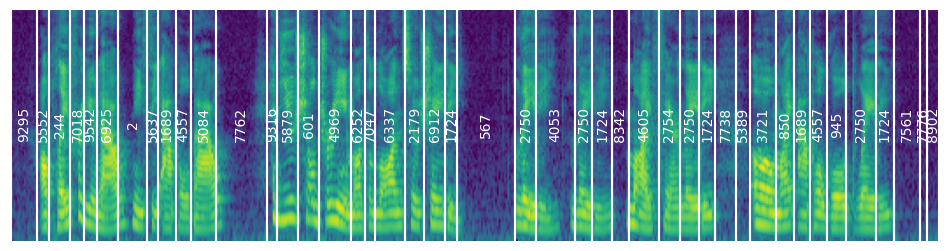

In [14]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 1, 1)
plt.imshow(melspec, aspect="auto", origin="lower")
plt.axis("off")
for b1, b2, id in zip(boundaries[:-1], boundaries[1:], ids):
    plt.axvline(b1, c="w")
    plt.axvline(b2, c="w")
    plt.text(
        (b1 + b2) / 2, 64, str(id.item()), rotation=90, c="w", ha="center", va="center"
    )